In [134]:
# In this notebook I prototype the two models used in AirbnBoost, (a) the topic model and (b) the pricing model.

# Topic model
# I am using a Latend Dirichlet Allocation (LDA) model to extract latent topics in Airbnb listing description. This way the user can easily select listings that match their taste. For instance, if the user is interested in searching for renovated listings with modern features, they can filter the topic #modern, which is extracted based on the topic model developed in this notebook.

# Pricing model
# I am using XGBoost to develop a pricing model, where I predict the price of each Airbnb listing in NYC using physical, urban, image, and topic modeling features. The pricing model aims to improve UX by adding a level of pricing transparency showing not only the actual listing price, but also its estimated price. This estimate reflects (assuming a robust and unbiased model) essentially how similar listings are priced.
# Moreover, based on the deviation between actual and estimated price the user can view underpriced listings, marked as great deals.

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from IPython.display import clear_output
import pickle
import shap
import matplotlib.pylab as plt

import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('punkt')
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.phrases import Phrases, Phraser
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS

import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%pylab inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zahra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zahra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Populating the interactive namespace from numpy and matplotlib


In [3]:
# "Tableau 10" and "Tableau 20" colors as RGB.
tableau10 = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scaling the RGB values to [0, 1] range - the format matplotlib accepts.    
for i in range(len(tableau10)):  
    r, g, b = tableau10[i]  
    tableau10[i] = (r / 255., g / 255., b / 255.)
    
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

%config InlineBackend.figure_format = 'retina'

In [4]:
# Data preprocessing
# Clean misreported data and bring to machine readable format
# Filter outliers in price using a logarithmic transformation and filtering out values that fall outside 2 standard deviations from the sample mean.
# Convert categorical features to dummy variables.
# Engineer new features (e.g. available the entire year, wifi provided, etc.)

In [5]:
df = pd.read_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\processed\combo.csv', low_memory=False)
df.reset_index(inplace=True)
#df.drop(['index','Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1'], axis=1, inplace=True)
df.drop(['index'], axis=1, inplace=True)
df = df[df.is_location_exact=='t']
df.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,flag_noLongerAvail,Coordinates,buffer_km,buffer_km_noise,close_sub,close_noise,close_groc
1,8077,https://www.airbnb.com/rooms/8077,20190808195523,2019-08-09,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,My husband and I are both artists. I give pain...,Guest room in a luxury condo with access to al...,none,NaN,NaN,NaN,NaN,NaN,No smoking please.,NaN,NaN,https://a0.muscache.com/im/pictures/11780344/1...,NaN,22795,https://www.airbnb.com/users/show/22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/9a077853-c...,https://a0.muscache.com/im/pictures/9a077853-c...,Harbourfront,2.0,2.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Toronto, ON, Canada",Downtown Toronto,Waterfront Communities-The Island,NaN,Toronto,ON,M5J,Toronto,"Toronto, Canada",CA,Canada,43.64105,-79.37628,t,Apartment,Private room,2,1.5,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$100.00,NaN,"$2,654.00","$2,654.00",NaN,1,$0.00,180,365,180,180,365,365,180.0,365.0,11 months ago,t,0,0,0,0,2019-08-09,169,0,2009-08-20,2013-08-27,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,strict_14_with_grace_period,f,t,2,1,1,0,1.39,0,POINT (-79.37628000000001 43.64105),"POLYGON ((-79.37268675530004 43.64105, -79.372...","POLYGON ((-79.37403422206253 43.64105, -79.374...",0,0,1
2,12604,https://www.airbnb.com/rooms/12604,20190808195523,2019-08-08,Seaton Village Parlour Bedroom,Comfortable sofa bed in airy main floor parlour.,Family of 4 (2 kids) plus a friendly dog open...,Comfortable sofa bed in airy main floor parlou...,none,NaN,NaN,NaN,NaN,NaN,no smoking,NaN,NaN,https://a0.muscache.com/im/pictures/5282025/91...,NaN,48239,https://www.airbnb.com/users/show/48239,Rona,2009-10-25,"Toronto, Ontario, Canada","I love travelling and exploring new places, ma...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/48239/profile...,https://a0.muscache.com/im/users/48239/profile...,The Annex,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Toronto, ON, Canada",The Annex,Annex,NaN,Toronto,ON,M6G,Toronto,"Toronto, Canada",CA,Canada,43.66724,-79.41598,t,House,Private room,1,1.5,1.0,1.0,Pull-out Sofa,"{In

In [6]:
df.close_sub = df.close_sub.apply(lambda x: 1 if x>0 else 0)
df.close_groc = df.close_groc.apply(lambda x: 1 if x>0 else 0)
df.close_noise = df.close_noise.apply(lambda x: 1 if x<1 else 0) #make no noise 1
#df.head(5)

In [7]:
#Convert price to numeric and remove outliers. Filter out listings that their price is higher or lower than 2σ from the sample mean.

df['price'] = df.price.apply(lambda x: x.replace('$', ''))
df['price'] = df.price.apply(lambda x: float(x.replace(',', '')))
df['extra_people'] = df.extra_people.apply(lambda x: float(x.replace('$', '')))
df['invalid_neigh'] = df.neighbourhood_cleansed.apply(lambda x: 1 if '$' in x else 0)
df = df[df.invalid_neigh==0]


def flag_outliers(x, series):
    """ 
    Flags airbnb listings that log(price) is more than 2 std from the sample mean.
  
    Parameters: 
    x: individual listing price
    series: series with all listings in the data
  
    Returns: 
    1: if outlier==TRUE
    0: otherwise
  
    """    
    series = series.replace(0, 0.01)
    # logarithmic transformation to normalize the data
    log = np.log(series)
    upper = np.mean(log) + np.std(log)*2
    lower = np.mean(log) - np.std(log)*2
    
    if np.log(x)<lower or np.log(x)>upper:
        return 1
    else:
        return 0
    
df['flag_price'] = df['price'].apply((lambda x: flag_outliers(x, df['price'])))
df = df[df.flag_price==0]

In [8]:
# remove listings without review rating
df.dropna(subset=['review_scores_rating'], inplace=True)

In [9]:
# Data preprocessing and additional feature engineering
df['response_rate_100'] = df.host_response_rate.apply(lambda x: 1 if x=='100%' else 0)
df['host_is_superhost'] = df['host_is_superhost'].apply(lambda x: 1 if x=='t' else 0)
df['host_has_profile_pic'] = df['host_has_profile_pic'].apply(lambda x: 1 if x=='t' else 0)
df['host_identity_verified'] = df['host_has_profile_pic'].apply(lambda x: 1 if x=='t' else 0)
df['instant_bookable'] = df['instant_bookable'].apply(lambda x: 1 if x=='t' else 0)
df['wifi'] = df['amenities'].apply(lambda x: 1 if 'Wifi' in x else 0)
df['TV'] = df['amenities'].apply(lambda x: 1 if 'TV' in x else 0)
df['noSecurityDeposit'] = df.security_deposit.apply(lambda x: 1 if x=='$0.00' else 0)
df['noCostExtraPeople'] = df.extra_people.apply(lambda x: 1 if x==0 else 0)
df['availFullYear'] = df.availability_365.apply(lambda x: 1 if x==365 else 0)

propTypes = ['Apartment', 'Bed and breakfast', 'Boutique hotel', 'Condominium', 'Condo', 'Guest suite', 'Guesthouse', 'Hostel',
'Hotel', 'House', 'Loft', 'Resort', 'Serviced apartment', 'Townhouse']

df['property_type'] = df['property_type'].apply(lambda x: x if x in propTypes else 'Other')

In [10]:
# get dummy variables
host_response = pd.get_dummies(df.host_response_time, prefix='respTime')
neighbor = pd.get_dummies(df.neighbourhood_cleansed, prefix='loc')
propType = pd.get_dummies(df.property_type, prefix='propType')
roomType = pd.get_dummies(df.room_type, prefix='roomType')
bedType = pd.get_dummies(df.bed_type, prefix='bedType')
cancelPol = pd.get_dummies(df.cancellation_policy, prefix='cancel')
boro = pd.get_dummies(df.neighbourhood_group_cleansed, prefix='boro')

tmp = pd.concat([df, host_response], axis=1)
tmp = pd.concat([tmp, neighbor], axis=1)
tmp = pd.concat([tmp, propType], axis=1)
tmp = pd.concat([tmp, roomType], axis=1)
tmp = pd.concat([tmp, bedType], axis=1)
tmp = pd.concat([tmp, cancelPol], axis=1)
tmp = pd.concat([tmp, boro], axis=1)

In [11]:
# Select features of interest to train the LDA and pricing model.

feats = ['host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
        'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60',
        'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy',
        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication','review_scores_location',
        'review_scores_value', 'price', 'reviews_per_month', 'close_sub', 'close_groc', 'close_noise', 'summary']

feats = feats + list(tmp.columns[113:])

data = tmp[feats]
data = data.dropna()
data.shape
#data.info()
#data.head()

(13457, 207)

In [12]:
# Topic modeling using LDA
# Extract the latent topics included in the listing descriptions. Pipeline:

# Preprocess listing descriptions (tokenize, remove stopwords, lemmatize).
# Create corpus using Bag of Words.
# Find optimal number of topics using LDA coherence scores.
# Use optimal LDA model to assign topics to listings.
# Find the most "interpretable" topics.
# Visualize topic clusters.
# Assign listing to topic if P(description belonging to topic)>0.7. The trheshold selection is arbitrary, but set high enough to minimize false positive rate.

In [54]:
text = data.summary

stop_words = gensim.parsing.preprocessing.STOPWORDS
stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()

# remove words that DO NOT characterize the listing itself
noise_words = ['toronto', 'people', 'traveller', 'travellers', 'traveler', 'apartment', 'building', 'bedroom', 'bedrooms', 'bathroom', 'kitchen', 'train', 'subway', 'central', 'downtown',
              'scarborough', 'street', 'city', 'place', 'space', 'guest', 'floor', 'state', 'close', 'dundas', 'public', 'distnace',
              'transit', 'great', 'neighbourhood', 'restaurant', 'restaurants', 'center', 'station', 'share', 'family', 'living', 'located',
              'location', 'youll', 'drive', 'block', 'blocks', 'square', 'walking', 'welcome', 'airbnb', 'minute', 'minutes', 'guests', 'guest', 'available']


def get_lemma(word):
    """ 
    Lemmatize a given word.
    
    Parameters: 
    word 

    Returns: 
    lemmatized version of word
  
    """      
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

    
def preprocessData(x):
    """ 
    Processes text for LDA topic modeling
  
    Parameters: 
    x: listing description summary
  
    Returns: 
    x: processed listing description
  
    """  
    x = x.lower() # convert to lower case
    x = re.sub(r"\d+", "", x) #remove numbers
    regex = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation
    x = regex.sub("", x)
    x = x.strip() # remove whitespaces
    x = word_tokenize(x) #tokenize
    #stop_words = gensim.parsing.preprocessing.STOPWORDS
    x = [i for i in x if not i in stop_words] # remove stopwords
    x = [i for i in x if not i in noise_words]
            
    x = [get_lemma(i) for i in x]
    x = [lemmatizer.lemmatize(i) for i in x] # lematize words
    x = [i for i in x if len(i) > 4]
    #x = [stemmer.stem(i) for i in x] # stem words
    return x 

In [55]:
#Text preprocessing.

text.replace(np.nan, '', inplace=True)

text_data = []

for i, line in enumerate(text):
    tokens = preprocessData(line)
    text_data.append(tokens)
    
    if i in np.arange(0,14000,1000):
        clear_output()
        print('Processed %s listings'%i)

Processed 13000 listings


In [56]:
bigram = gensim.models.Phrases(text_data, min_count=10, threshold=50)
text_data_bigrams = [bigram[line] for line in text_data]

In [57]:
# Get corpus and dictionary.

dictionary = corpora.Dictionary(text_data_bigrams)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)  #also check 15 and 0.5, 10 and 0.2
corpus = [dictionary.doc2bow(text) for text in text_data_bigrams]

In [59]:
# Find optimal number of topics.
coherence_values = []
model_list = []
for numTopics in range(3,50): #check till 100
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = numTopics, id2word=dictionary, passes=1,  random_state=25)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_data_bigrams, dictionary=dictionary, coherence='c_v')
    coherence_score=coherence_model_lda.get_coherence()
    coherence_values.append(coherence_score)
    print('NumTopis:', numTopics, '-- Coherence Score:', coherence_score)


NumTopis: 3 -- Coherence Score: 0.3972030834535832
NumTopis: 4 -- Coherence Score: 0.4123603686949582
NumTopis: 5 -- Coherence Score: 0.3820466327044875
NumTopis: 6 -- Coherence Score: 0.3944472464335223
NumTopis: 7 -- Coherence Score: 0.40192082701865794
NumTopis: 8 -- Coherence Score: 0.39332865876544676
NumTopis: 9 -- Coherence Score: 0.3897696381009409
NumTopis: 10 -- Coherence Score: 0.3926237920355352
NumTopis: 11 -- Coherence Score: 0.39489652362261685
NumTopis: 12 -- Coherence Score: 0.38861931096268815
NumTopis: 13 -- Coherence Score: 0.39530026973468463
NumTopis: 14 -- Coherence Score: 0.39958842655229343
NumTopis: 15 -- Coherence Score: 0.41522122173331183
NumTopis: 16 -- Coherence Score: 0.42412443637602676
NumTopis: 17 -- Coherence Score: 0.41990043917764686
NumTopis: 18 -- Coherence Score: 0.4158574969057544
NumTopis: 19 -- Coherence Score: 0.4036833998212032
NumTopis: 20 -- Coherence Score: 0.3885881074833349
NumTopis: 21 -- Coherence Score: 0.39838972709701326
NumTopis:

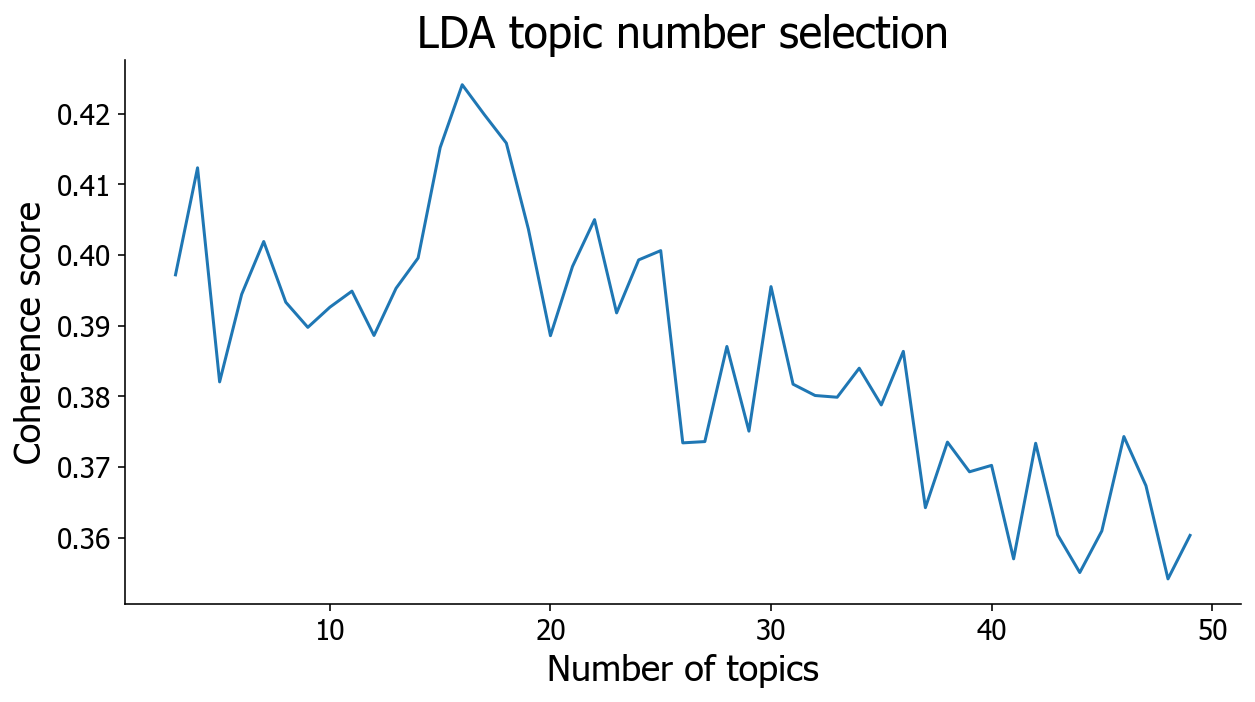

In [60]:
# visualize coherence scores
x = range(3, 50)
plt.figure(figsize=(10,5))
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('LDA topic number selection')
plt.plot(x, coherence_values)

plt.savefig(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\processed\lda_topic_no_select.png')

In [61]:
#Train the optimal LDA model.

numTopics = 16
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=numTopics, id2word=dictionary, passes=10, random_state=25) 
#iterations = 50-400, #alpha='auto', eta='auto' #eval_every=1 
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.105*"centre" + 0.084*"tower" + 0.063*"district" + 0.058*"rogers"')
(1, '0.103*"store" + 0.094*"grocery" + 0.037*"distance" + 0.028*"shopping"')
(2, '0.045*"beach" + 0.038*"transit" + 0.025*"beautiful" + 0.025*"access"')
(3, '0.046*"basement" + 0.030*"parking" + 0.030*"washroom" + 0.029*"house"')
(4, '0.138*"house" + 0.059*"quiet" + 0.023*"clean" + 0.022*"lovely"')
(5, '0.038*"ceiling" + 0.031*"window" + 0.030*"design" + 0.023*"modern"')
(6, '0.062*"university" + 0.057*"eaton" + 0.046*"centre" + 0.034*"yonge"')
(7, '0.048*"queen" + 0.041*"large" + 0.030*"couch" + 0.027*"comfortable"')
(8, '0.057*"fully" + 0.054*"parking" + 0.042*"furnish" + 0.032*"equip"')
(9, '0.050*"toronto" + 0.043*"attraction" + 0.030*"experience" + 0.029*"youll"')
(10, '0.050*"brand" + 0.044*"appliance" + 0.032*"furniture" + 0.022*"dishwasher"')
(11, '0.126*"business" + 0.088*"perfect" + 0.086*"couple" + 0.064*"family"')
(12, '0.063*"enjoy" + 0.046*"relax" + 0.036*"perfect" + 0.029*"offer"')
(13, '0.075*"dri

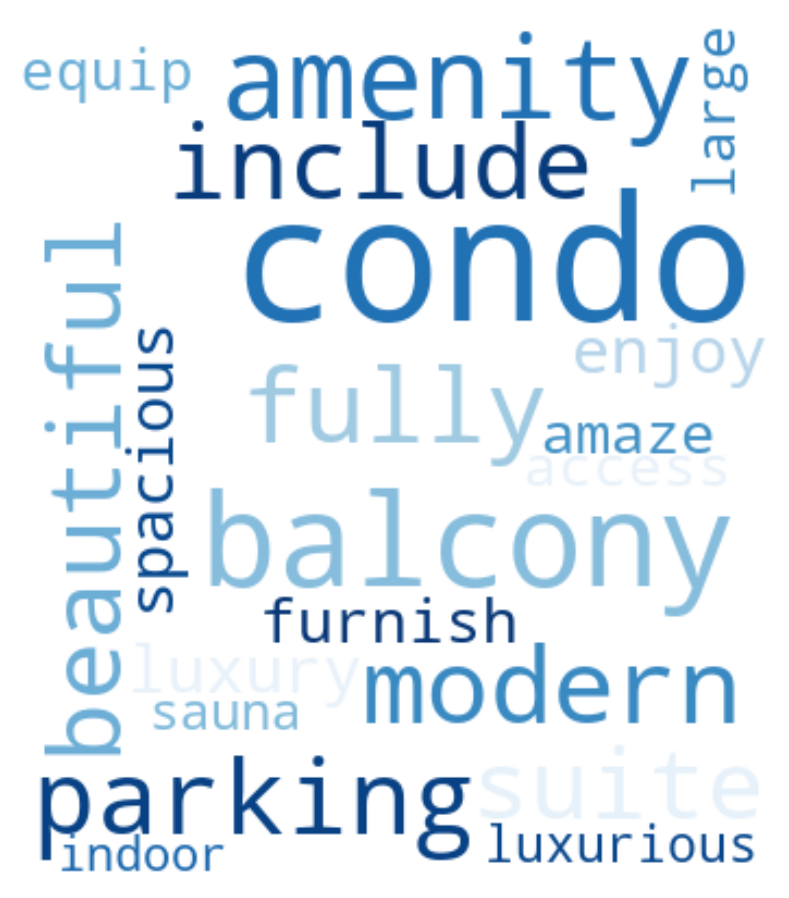

In [78]:
ldamodel.save('lda_model.gensim')
#ldamodel = gensim.models.ldamodel.LdaModel.load('lda_model.gensim')

#Make word clouds. - Modern 

plt.imshow(WordCloud(width=350, height=400, max_font_size=80, max_words=50, collocations=True, colormap="Blues", background_color="white", 
                     random_state=35).fit_words(dict(ldamodel.show_topic(14, 20))), interpolation="bilinear")
plt.axis("off")
plt.savefig(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project\data\processed\wordcloud_Modern.png')
plt.show()

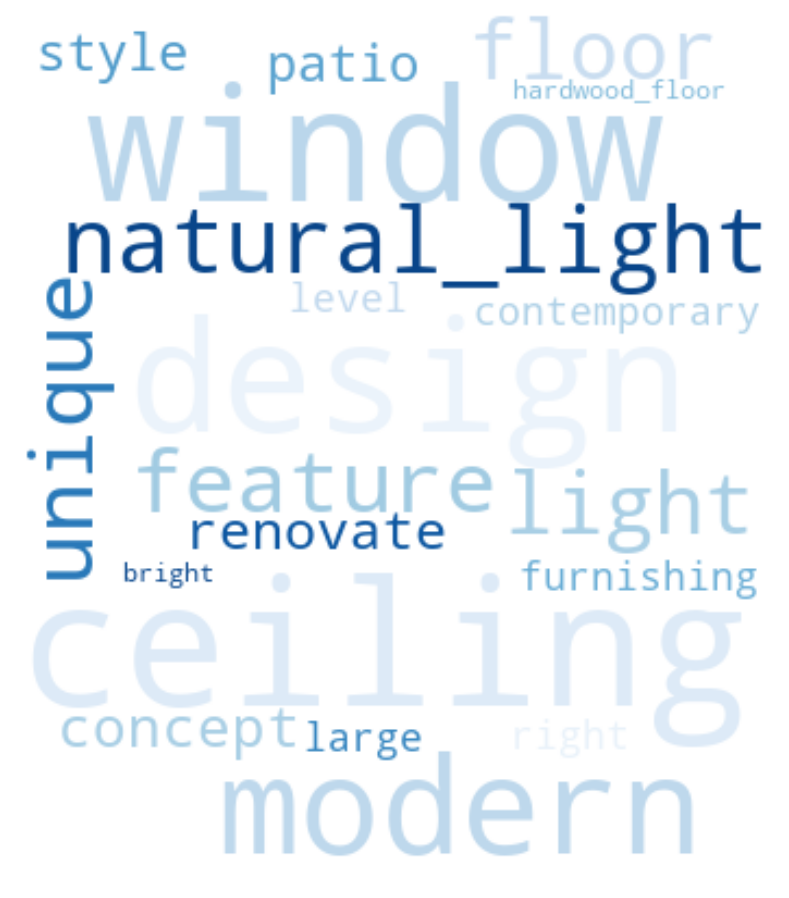

In [83]:
# Aesthetic 

plt.imshow(WordCloud(width=350, height=400, max_font_size=80, max_words=50, collocations=True, colormap="Blues",
                         background_color="white", random_state=35).fit_words(dict(ldamodel.show_topic(5, 20))), interpolation="bilinear")
plt.axis("off")
plt.savefig(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project\data\processed\wordcloud_Aesthetics.png')
plt.show()

In [81]:
# Visualize topics with pyLDAvis.

pyLDAvis.enable_notebook()
ldaVis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
ldaVis
# from IPython.display import HTML
# HTML(filename='topicModelingVis.html')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.199130  0.165617       1        1  10.411556
3      0.195151 -0.132533       2        1   9.631084
14     0.133774  0.148277       3        1   8.965261
2     -0.111083 -0.095655       4        1   7.275545
1     -0.144429 -0.224790       5        1   6.983201
15    -0.111400 -0.061301       6        1   6.302653
8      0.187511 -0.012010       7        1   6.162328
4      0.034616 -0.188351       8        1   5.995259
7      0.235338  0.028781       9        1   5.529967
12    -0.005551  0.143466      10        1   5.351005
11    -0.035188  0.066616      11        1   5.303498
5      0.104422  0.123595      12        1   5.008173
9     -0.148291  0.188369      13        1   4.584906
6     -0.263968  0.008425      14        1   4.480085
13    -0.021585 -0.205509      15        1   4.360301
10     0.149814  0.047002      16        1   3.655177, topic_info=    Category         Freq            Term        Total  loglift  logprob
6    Default  2929.000000          centre  2929.000000  30.0000  30.0000
95   Default  2525.000000           house  2525.000000  29.0000  29.0000
183  Default  1428.000000        business  1428.000000  28.0000  28.0000
12   Default  2076.000000           tower  2076.000000  27.0000  27.0000
145  Default  1576.000000           store  1576.000000  26.0000  26.0000
..       ...          ...             ...          ...      ...      ...
109  Topic16    73.465904           cable   367.344299   1.6995  -4.6666
117  Topic16    71.189278  newly_renovate   850.934509   0.8280  -4.6981
34   Topic16    77.059044           large  1678.567749   0.2279  -4.6189
48   Topic16    61.308804         ceiling   780.699158   0.7648  -4.8475
28   Topic16    60.900440          studio   735.039429   0.8183  -4.8542

[1003 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
970      11  0.959530     abode
331      13  0.965863  abundant
0         1  0.059688    access
0         2  0.107438    access
0         3  0.166607    access
...     ...       ...       ...
30        1  0.055326     youre
30        4  0.034047     youre
30        6  0.195770     youre
30       10  0.229817     youre
30       13  0.480914     youre

[1906 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 15, 3, 2, 16, 9, 5, 8, 13, 12, 6, 10, 7, 14, 11])

In [138]:
# save visualization
pyLDAvis.save_html(ldaVis, 'topicModelingVis.html')

In [85]:
# assign topics to listings

def assignTopic(new_doc):
    """ 
    Characterize listings based on their description
    
    Parameters: 
    new_doc: document including listing summary 

    Returns: 
    Topic characterization or None if topic is not assigned
  
    """ 
    new_doc = preprocessData(new_doc)
    new_doc_bow = dictionary.doc2bow(new_doc) # convert document to bag of words
    topic_ass = ldamodel.get_document_topics(new_doc_bow) # get topic likelihood for given document
    idx  = [i[0] for i in topic_ass if i[1]>0.70] # set threshold: P(belonging_to_topic)>0.7
    try:
        if idx[0] == 14:
            return 'modern'
        elif idx[0] == 5:
            return 'aesthetics'
    except:
        return None

In [74]:
data['hashtag'] = data.summary.apply(assignTopic)

In [75]:
# count assignments in each topic
data.groupby('hashtag')['hashtag'].count()

hashtag
aesthetics     26
modern        112
Name: hashtag, dtype: int64

In [76]:
data.groupby('hashtag')['price'].median()

hashtag
aesthetics    194.5
modern        147.0
Name: price, dtype: float64

In [79]:
print ('Median Airbnb listing price:', data.price.median())

Median Airbnb listing price: 100.0


In [80]:
# get dummy variables from hashtags
hashDummies = pd.get_dummies(data.hashtag, prefix='hashtag')
data = pd.concat([data, hashDummies], axis=1)

In [86]:
data.to_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\processed\data.csv', index=False)

In [101]:
data = pd.read_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\processed\data.csv')
#df.reset_index(inplace=True)
data.head(5)

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,reviews_per_month,close_sub,close_groc,close_noise,summary,invalid_neigh,flag_price,response_rate_100,wifi,TV,noSecurityDeposit,noCostExtraPeople,availFullYear,respTime_a few days or more,respTime_within a day,respTime_within a few hours,respTime_within an hour,loc_Agincourt North,loc_Agincourt South-Malvern West,loc_Alderwood,loc_Annex,loc_Banbury-Don Mills,loc_Bathurst Manor,loc_Bay Street Corridor,loc_Bayview Village,loc_Bayview Woods-Steeles,loc_Bedford Park-Nortown,loc_Beechborough-Greenbrook,loc_Bendale,loc_Birchcliffe-Cliffside,loc_Black Creek,loc_Blake-Jones,loc_Briar Hill-Belgravia,loc_Bridle Path-Sunnybrook-York Mills,loc_Broadview North,loc_Brookhaven-Amesbury,loc_Cabbagetown-South St.James Town,loc_Caledonia-Fairbank,loc_Casa Loma,loc_Centennial Scarborough,loc_Church-Yonge Corridor,loc_Clairlea-Birchmount,loc_Clanton Park,loc_Cliffcrest,loc_Corso Italia-Davenport,loc_Danforth,loc_Danforth East York,loc_Don Valley Village,loc_Dorset Park,loc_Dovercourt-Wallace Emerson-Junction,loc_Downsview-Roding-CFB,loc_Dufferin Grove,loc_East End-Danforth,loc_Edenbridge-Humber Valley,loc_Eglinton East,loc_Elms-Old Rexdale,loc_Englemount-Lawrence,loc_Eringate-Centennial-West Deane,loc_Etobicoke West Mall,loc_Flemingdon Park,loc_Forest Hill North,loc_Forest Hill South,loc_Glenfield-Jane Heights,loc_Greenwood-Coxwell,loc_Guildwood,loc_Henry Farm,loc_High Park North,loc_High Park-Swansea,loc_Highland Creek,loc_Hillcrest Village,loc_Humber Heights-Westmount,loc_Humber Summit,loc_Humbermede,loc_Humewood-Cedarvale,loc_Ionview,loc_Islington-City Centre West,loc_Junction Area,loc_Keelesdale-Eglinton West,loc_Kennedy Park,loc_Kensington-Chinatown,loc_Kingsview Village-The Westway,loc_Kingsway South,loc_L'Amoreaux,loc_Lambton Baby Point,loc_Lansing-Westgate,loc_Lawrence Park North,loc_Lawrence Park South,loc_Leaside-Bennington,loc_Little Portugal,loc_Long Branch,loc_Malvern,loc_Maple Leaf,loc_Markland Wood,loc_Milliken,loc_Mimico (includes Humber Bay Shores),loc_Morningside,loc_Moss Park,loc_Mount Dennis,loc_Mount Olive-Silverstone-Jamestown,loc_Mount Pleasant East,loc_Mount Pleasant West,loc_New Toronto,loc_Newtonbrook East,loc_Newtonbrook West,loc_Niagara,loc_North Riverdale,loc_North St.James Town,loc_O'Connor-Parkview,loc_Oakridge,loc_Oakwood Village,loc_Old East York,loc_Palmerston-Little Italy,loc_Parkwoods-Donalda,loc_Pelmo Park-Humberlea,loc_Playter Estates-Danforth,loc_Pleasant View,loc_Princess-Rosethorn,loc_Regent Park,loc_Rexdale-Kipling,loc_Rockcliffe-Smythe,loc_Roncesvalles,loc_Rosedale-Moore Park,loc_Rouge,loc_Runnymede-Bloor West Village,loc_Rustic,loc_Scarborough Village,loc_South Parkdale,loc_South Riverdale,loc_St.Andrew-Windfields,loc_Steeles,loc_Stonegate-Queensway,loc_Tam O'Shanter-Sullivan,loc_Taylor-Massey,loc_The Beaches,loc_Thistletown-Beaumond Heights,loc_Thorncliffe Park,loc_Trinity-Bellwoods,loc_University,loc_Victoria Village,loc_Waterfront Communities-The Island,loc_West Hill,loc_West Humber-Clairville,loc_Westminster-Branson,loc_Weston,loc_Weston-Pellam Park,loc_Wexford/Maryvale,loc_Willowdale East,loc_Willowdale West,loc_Willowridge-Martingrove-Richview,loc_Woburn,loc_Woodbine Corridor,loc_Woodbine-Lumsden,loc_Wychwood,loc_Yonge-Eglinton,loc_Yonge-St.Clair,loc_York University Heights,loc_Yorkdale-Glen Park,propType_Apartment,propType_Bed and breakfast,propType_Boutique hotel,propType_Condominium,propType_Guest suite,propType_Guesthouse,propType_Hostel,propType_Hotel,propType_House,propType_Loft,propType_Other,propType_Serviced apartment,propType_Townhouse,roomType_Entire home/apt,roomType_Private 

In [ ]:
#PRICING MODEL

In [31]:
#XGBoost Model Selection 

In [102]:
# set features and target
X = data.drop(['price', 'hashtag', 'summary'], axis=1)
y = data.price

# split 80/20 train-validation set
Xt, Xv, yt, yv = train_test_split(X, np.log(y), test_size=0.2, random_state=14)
dtrain = xgb.DMatrix(Xt.as_matrix(), label=yt.as_matrix())
dtest = xgb.DMatrix(Xv.as_matrix(), label=yv.as_matrix())

In [103]:
# Run 5-fold CV

#initialize params
params = {'max_depth':3,
    'learning_rate':.3}

min_rmse = float("Inf")
best_params = None

count=0

for learning_rate in [.2, .1, .05]:
    for max_depth in range(3,7):
        clear_output()
        print("CV with learning_rate={}".format(learning_rate))
        print("CV with max_depth={}".format(max_depth))

        # update parameters
        params['learning_rate'] = learning_rate
        params['max_depth'] = max_depth

        # run and time CV
        %time cv_results = xgb.cv(params,dtrain,num_boost_round=1000,seed=25,nfold=5, metrics=['rmse'], early_stopping_rounds=20)

        # update best score
        mean_rmse = cv_results['test-rmse-mean'].min()
        boost_rounds = cv_results['test-rmse-mean'].idxmin()
        print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
        if mean_rmse < min_rmse:
            min_rmse = mean_rmse

            best_params = {'learning_rate': learning_rate, 'max_depth':max_depth}
            best_trees = boost_rounds

print('=='*60)
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

# pickle optimal hyperparameters
best_params['random_state'] = 25
best_params['n_estimators'] = best_trees
pickle.dump(best_params, open('xgboost_params.pkl', 'wb'))

CV with learning_rate=0.05
CV with max_depth=6
Wall time: 2min 45s
	RMSE 0.323994 for 544 rounds

Best params: {'learning_rate': 0.05, 'max_depth': 6}, RMSE: 0.323994


In [104]:
# XGBoost model

def mean_absolute_percentage_error(y_true, y_pred): 
    """ 
    Calculates mean absolute percentage error.
    
    Parameters: 
    y_true: series/array of observed values
    y_pred: series/array of predicted values

    Returns: 
    mean absolute percentage error
  
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [105]:
print ("The optimal XGBoost parameters are:")
opt_params = pickle.load(open('xgboost_params.pkl', 'rb'))
opt_params

The optimal XGBoost parameters are:


{'learning_rate': 0.05,
 'max_depth': 6,
 'random_state': 25,
 'n_estimators': 544}

In [106]:
mdl = xgb.XGBRegressor(**opt_params)
mdl.fit(Xt, yt)

[12:56:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=544,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=25,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [107]:
print ("Training R2:", mdl.score(Xt, yt))
print ("Testing R2:", mdl.score(Xv, yv))
print ('')
print ("Training RMSE:", sqrt(mean_squared_error(yt, mdl.predict(Xt))))
print ("Testing RMSE:", sqrt(mean_squared_error(yv, mdl.predict(Xv))))
print ('')
print ("Training MAE:", median_absolute_error(yt, mdl.predict(Xt)))
print ("Testing MAE:", median_absolute_error(yv, mdl.predict(Xv)))

Training R2: 0.8399642056285201
Testing R2: 0.716661557008065

Training RMSE: 0.24100491660019602
Testing RMSE: 0.32107070543814786

Training MAE: 0.14439453038058447
Testing MAE: 0.202344961636427


In [108]:
# Fit model on full dataset

mdlFinal = xgb.XGBRegressor(**opt_params)
mdlFinal.fit(X, np.log(y))

print ("XGBoost model R2:", mdlFinal.score(X,np.log(y)))
print ("XGBoost model MAE:", median_absolute_error(y, np.exp(mdlFinal.predict(X))))

[13:00:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost model R2: 0.8298579858264901
XGBoost model MAE: 14.784408569335938


In [ ]:
#Model interpretation and diagnostics

In [109]:
# Plot error diagnostics.

# set price estimates
data['priceEstimate'] = np.exp(mdlFinal.predict(X))

# error term
yPred = np.exp(mdlFinal.predict(X))
yPred_log = mdlFinal.predict(X)
err = y - yPred
errLog = np.log(y) - yPred_log

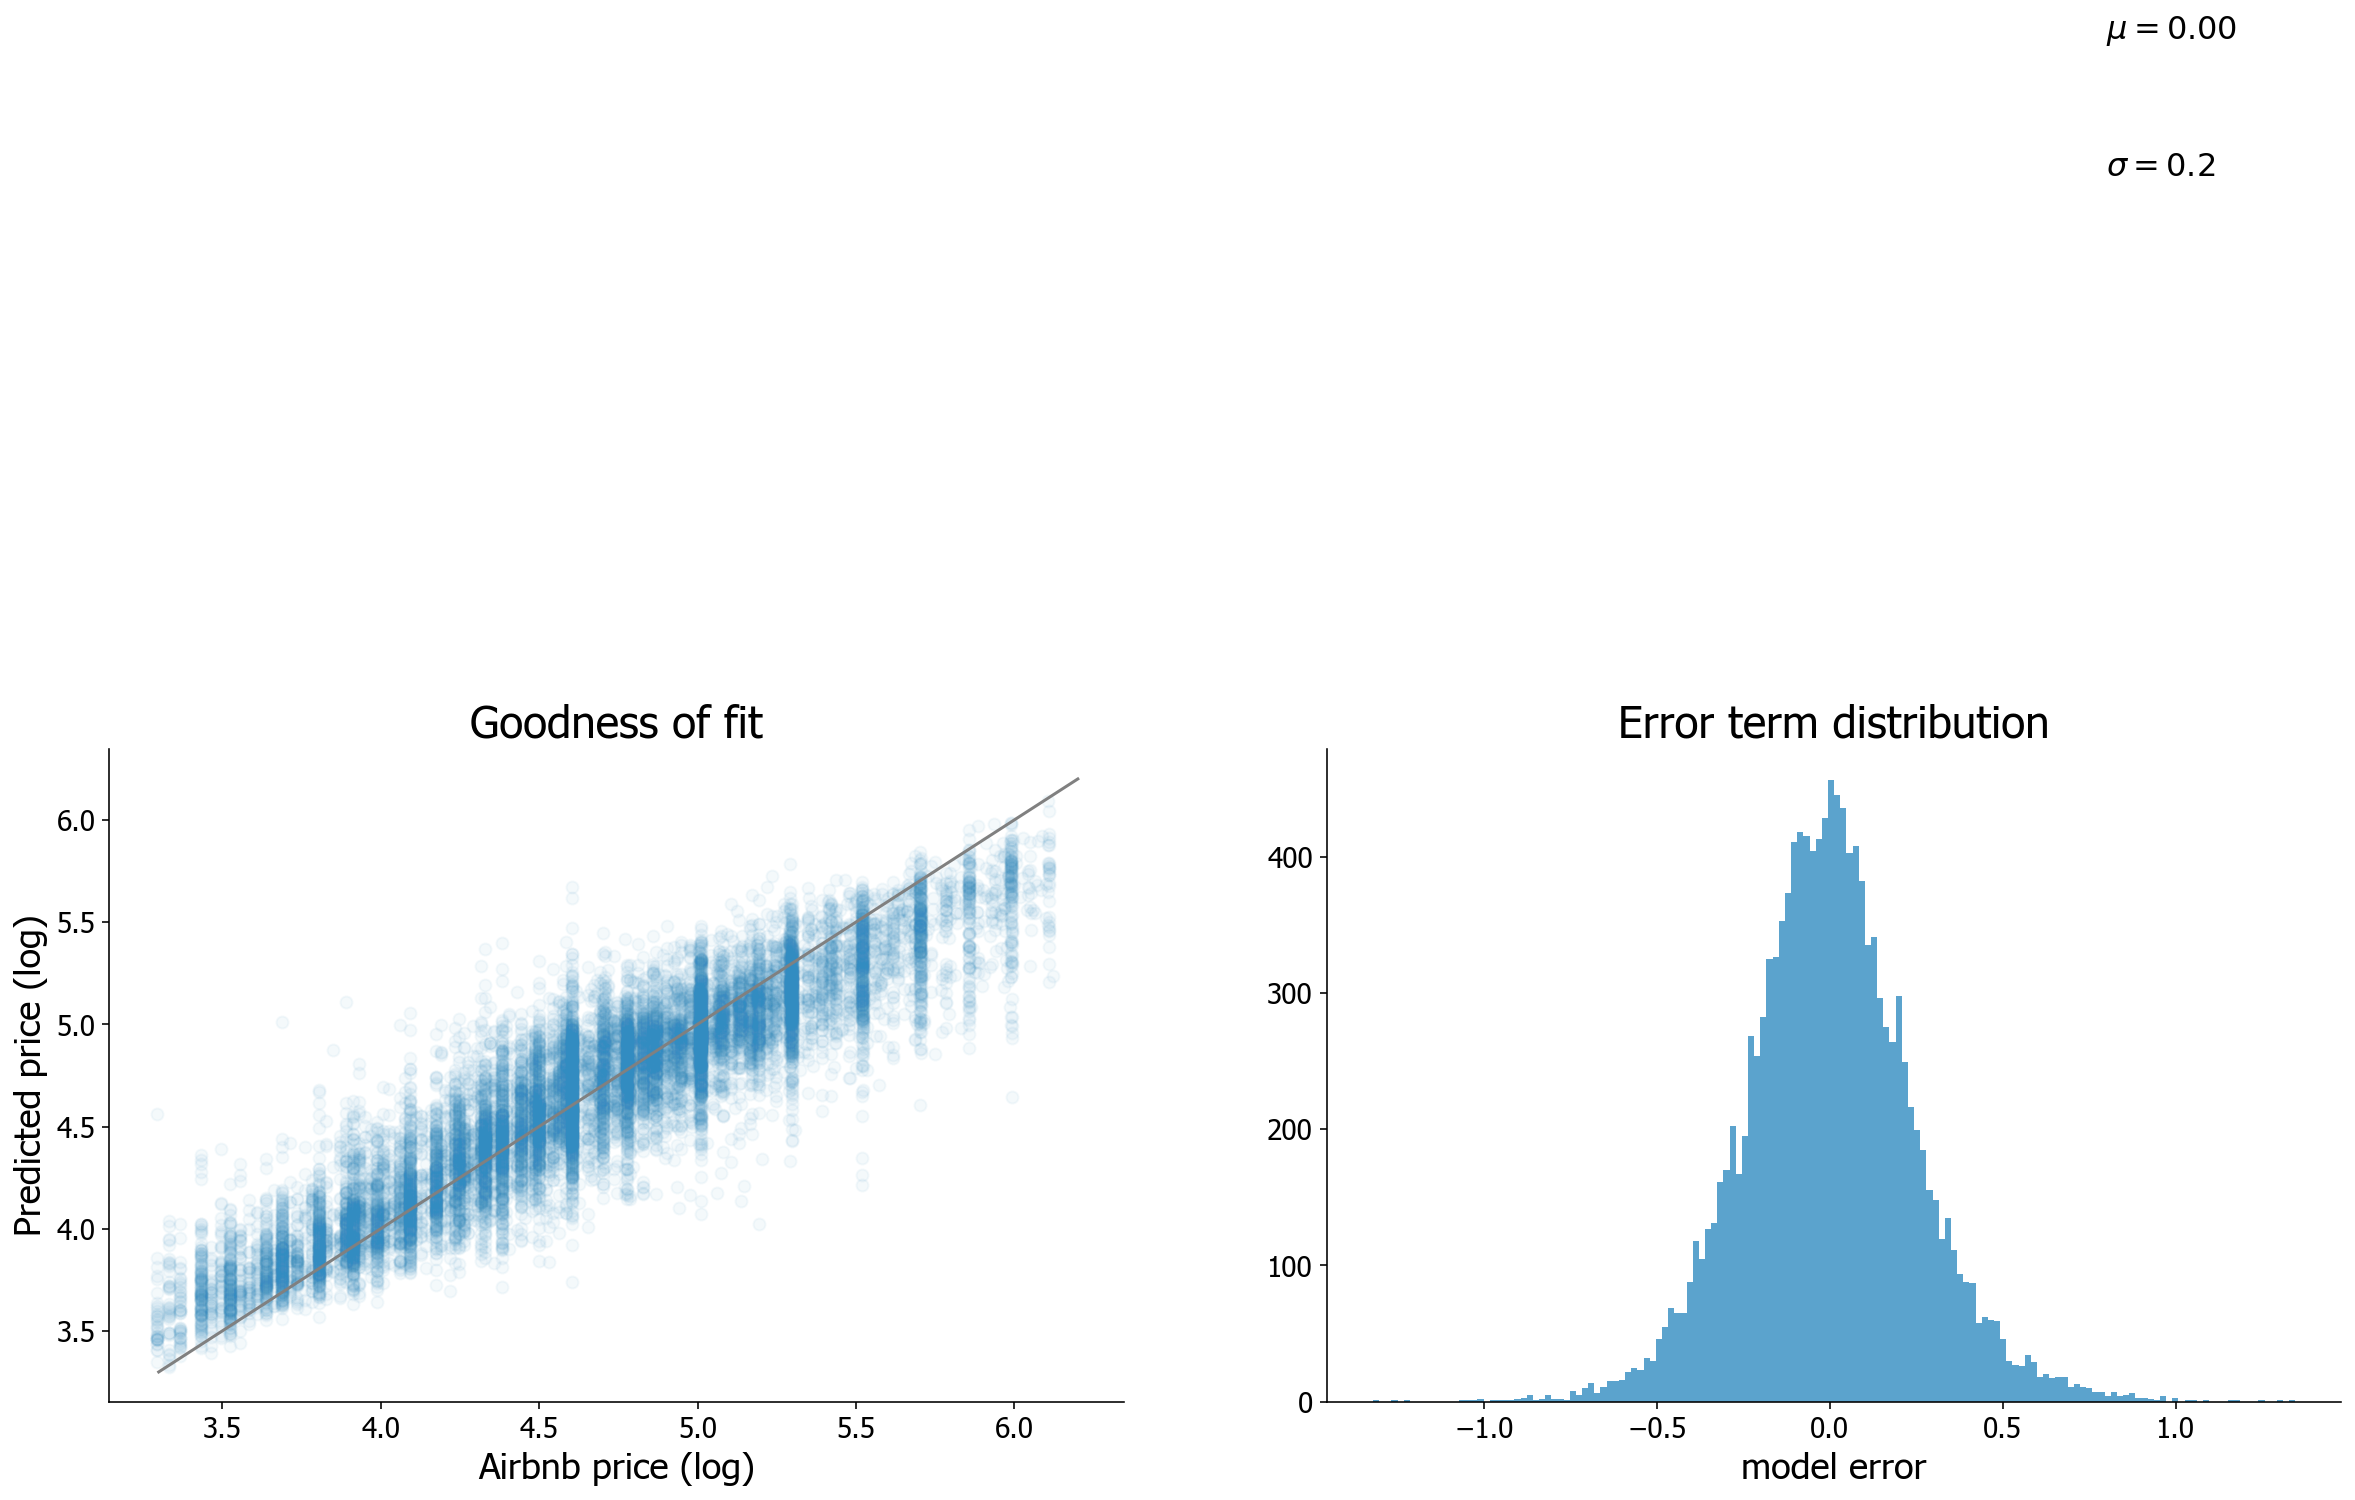

In [110]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.scatter(np.log(y), yPred_log, color="#328cc1", alpha=.05)
plt.xlabel('Airbnb price (log)')
plt.ylabel('Predicted price (log)')
plt.plot([3.3, 6.2], [3.3, 6.2], lw=1.5, color='gray')
plt.title('Goodness of fit')
plt.subplot(122)
plt.hist(errLog, bins=150, color="#328cc1", alpha=.8)
plt.xlabel('model error')
plt.title('Error term distribution')
plt.text(0.8, 1000, '$\mu = %.2f$'%errLog.mean(), size=16)
plt.text(0.8, 900, '$\sigma = %.1f$'%errLog.std(), size=16)
plt.savefig(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project\notebooks\output\model_error.png')
plt.show()

In [112]:
# Feature importance using SHAP

# obtain shap values
shap_values = shap.TreeExplainer(mdlFinal).shap_values(X)

In [113]:
shap_imp = pd.DataFrame({'feat': X.columns, 'imp':np.abs(shap_values).mean(0)})
shap_imp = shap_imp.sort_values('imp', ascending=False)
shap_imp

,feat,imp
192,roomType_Entire home/apt,0.250275
4,accommodates,0.081921
161,loc_Waterfront Communities-The Island,0.080124
6,bedrooms,0.063023
5,bathrooms,0.042836
23,reviews_per_month,0.035941
8,guests_included,0.032962
11,availability_30,0.032819
33,noCostExtraPeople,0.032506
182,propType_Condominium,0.031775


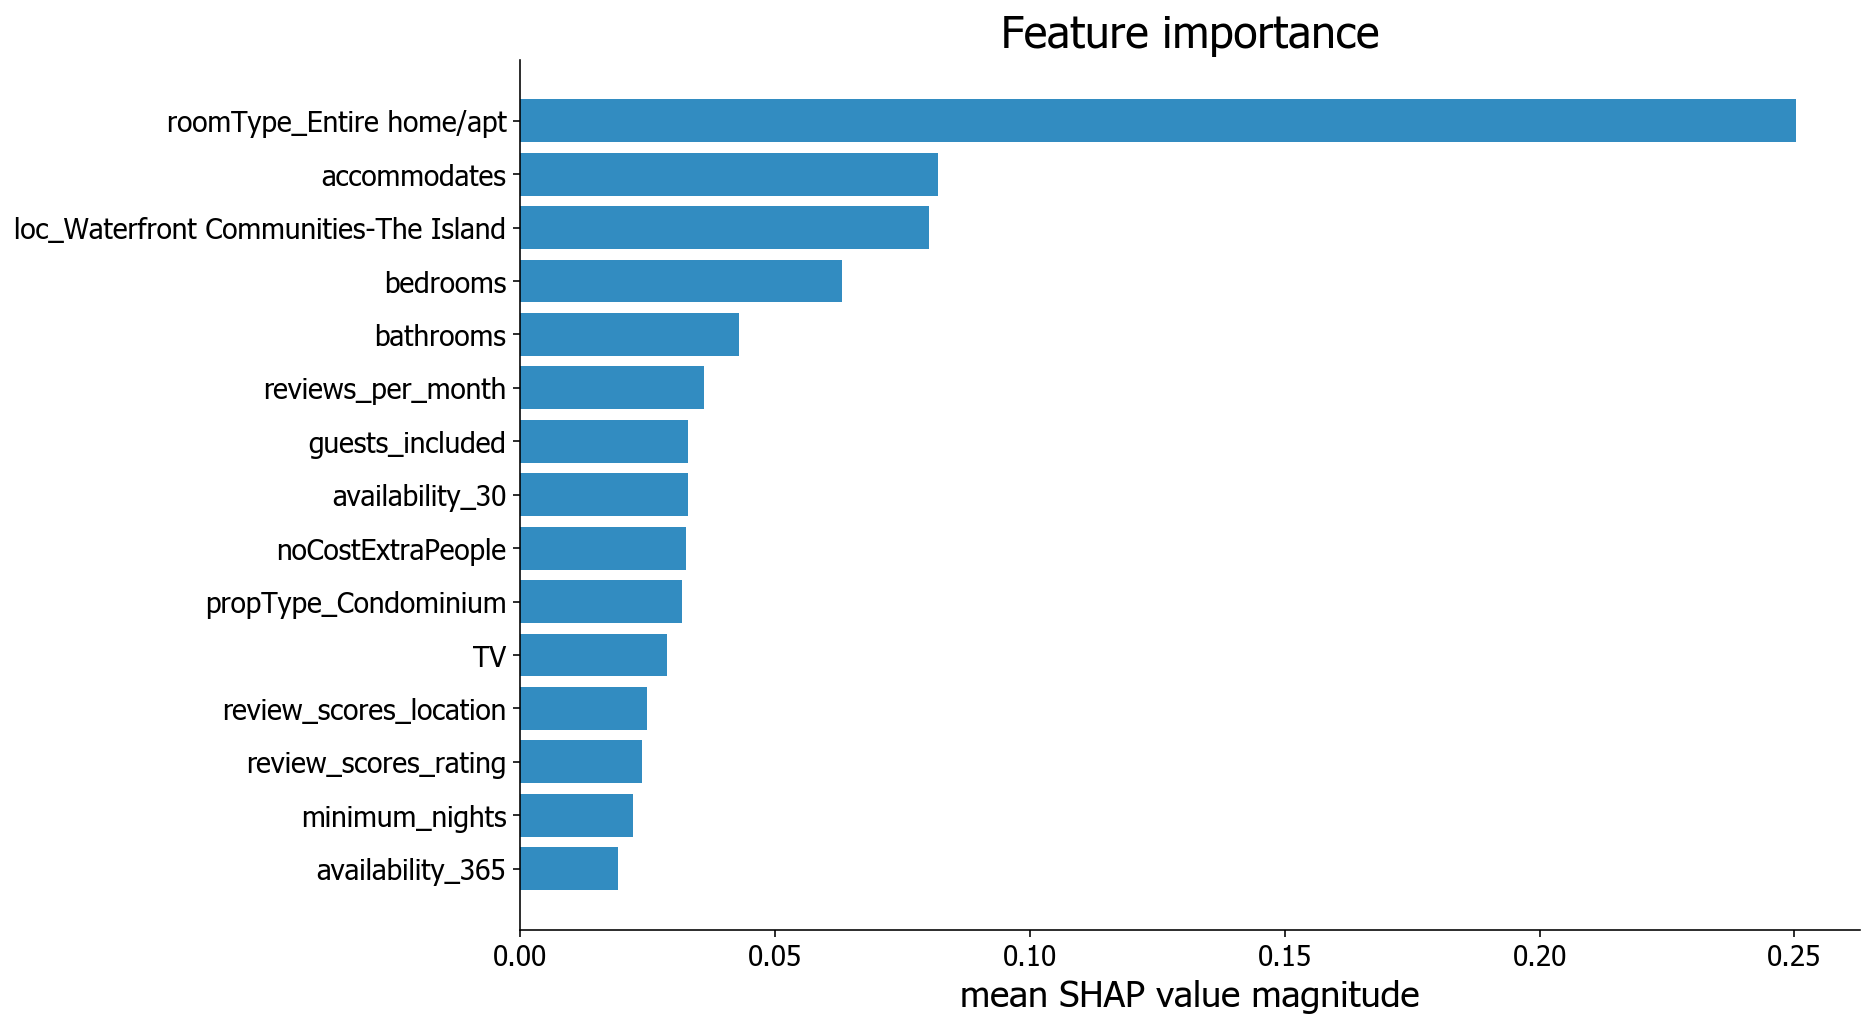

In [115]:
show_top = 15
global_shap_vals = np.abs(shap_values).mean(0)
inds = np.argsort(global_shap_vals)
y_pos = np.arange(X.shape[1])
plt.barh(range(show_top), shap_imp.imp.iloc[:show_top], color="#328cc1")
plt.yticks(range(show_top), shap_imp.feat.iloc[:show_top])
plt.xlabel("mean SHAP value magnitude")
plt.gca().invert_yaxis()
plt.title('Feature importance')
plt.savefig(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project\notebooks\output\shap_featImp.png', bbox_inches = "tight")
plt.show()

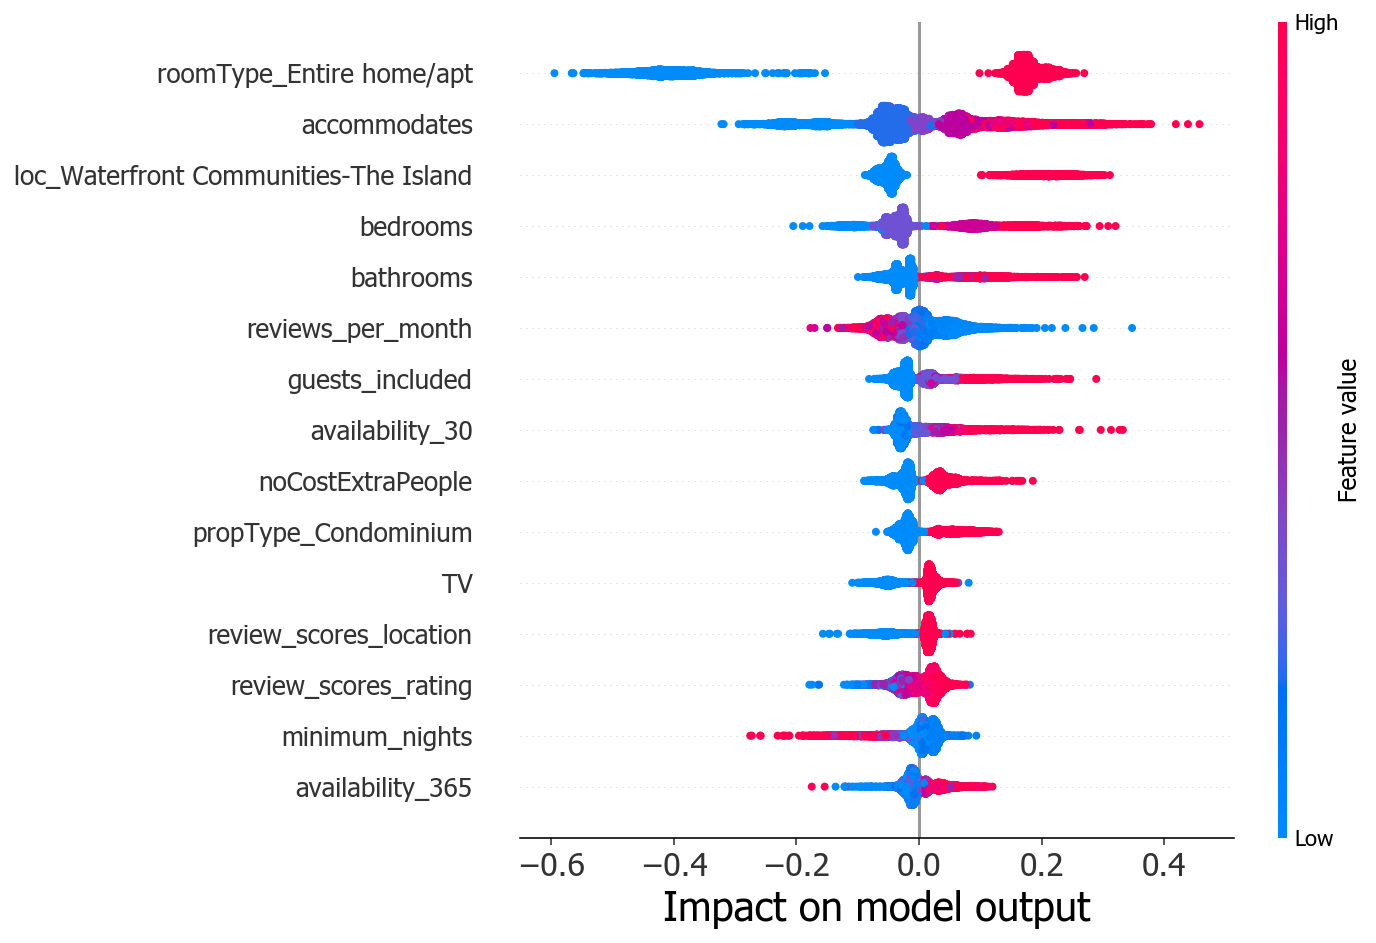

In [117]:
# Classic feature importance using SHAP.

plt.figure(figsize=(9,6))
shap.summary_plot(shap_values, X, title='SHAP values', max_display=15, auto_size_plot=True, show=False)
plt.xticks(size=16)
plt.xlabel('Impact on model output',size=20)
plt.savefig(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project\notebooks\output\shap_tree.png', bbox_inches = "tight")
plt.show()

In [32]:
#Output results

In [123]:
# Save model outputs and relevant features for the front-end.

dfOut = df[['listing_url', 'name', 'picture_url', 'latitude', 'longitude']]

output = data[['accommodates', 'guests_included', 'bathrooms', 'bedrooms', 'beds', 'price', 'priceEstimate',
                 'close_sub', 'close_groc', 'close_noise', 'hashtag']]

out = pd.merge(dfOut, output, left_index=True, right_index=True)
out['price'] = out['price'].apply(lambda x: round(x))
out['priceEstimate'] = out['priceEstimate'].apply(lambda x: round(x))

In [127]:
# Add some features for better UX.

out['error'] = errLog

def greatDeals(x, series):
    """ 
    Find great deals based on the error of the model prediction
    
    Parameters: 
    x: individual error term
    series: series of error terms

    Returns: 
    TRUE is error is more than 3x std lower than mean (i.e. underpriced listings)
  
    """ 
    lower = np.mean(series) - np.std(series)*3
    if x<lower:
        return 'TRUE'
    else:
        return None
    
# flag great deals
out['greatDeal'] = out['error'].apply((lambda x: greatDeals(x, out['error'])))

# bin noise complaints in 3 quantiles for better UX
#out['noise'] = pd.qcut(out.close_noise, 2, labels=["1", "0"])

# get booleans for proximity to subway and grocery stores
out['closeSubway'] = out.close_sub.apply(lambda x: 'TRUE' if x==1 else None)
out['closeGrocery'] = out.close_groc.apply(lambda x: 'TRUE' if x==1 else None)

In [128]:
# output end results and save to csv
final = out
final.drop(['error', 'close_sub', 'close_groc'], axis=1, inplace=True)
final.to_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\notebooks\output\dataForFrontEnd.csv', index=False)

In [ ]:
# Pricing model - Additional validation

In [ ]:
# In this Section I check for potential spatial bias in the pricing model's predictions

In [130]:
dfMerg = pd.merge(df[['neighbourhood_cleansed','neighbourhood_group_cleansed', 'zipcode', 'Coordinates']], final, left_index=True, right_index=True)
dfMerg['log_error'] = np.log(dfMerg.price) - np.log(dfMerg.priceEstimate)
dfMerg['error'] = dfMerg.price - dfMerg.priceEstimate
dfMerg.groupby('neighbourhood_group_cleansed').median()

,latitude,longitude,accommodates,guests_included,bathrooms,bedrooms,beds,price,priceEstimate,close_noise,log_error,error
neighbourhood_group_cleansed,,,,,,,,,,,,


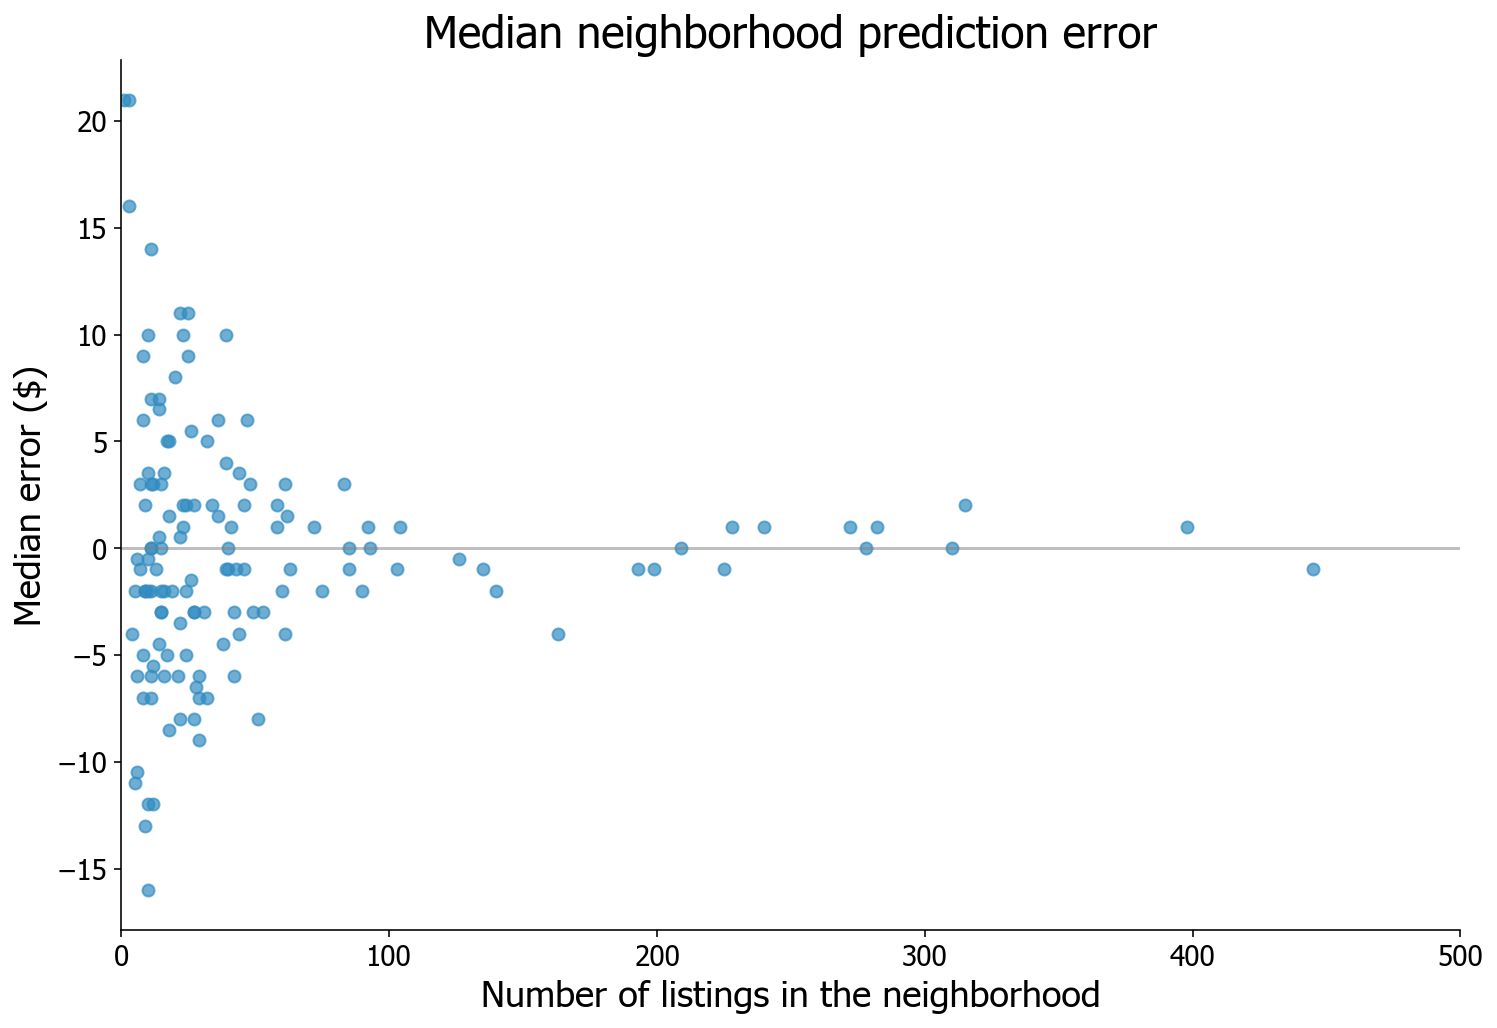

In [131]:
plt.scatter(dfMerg.groupby('neighbourhood_cleansed').count()['error'], 
            dfMerg.groupby('neighbourhood_cleansed').median()['error'], color="#328cc1", alpha=.7)
plt.xlim(0,500)
plt.axhline(y=0, color='gray', alpha=.5)
plt.title('Median neighborhood prediction error')
plt.xlabel('Number of listings in the neighborhood')
plt.ylabel('Median error ($)')
plt.savefig(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\notebooks\output\spatial_dist_error.png', bbox_inches="tight")
plt.show()

In [137]:
# load toronto postal codes shapefile
zipCodes = gpd.read_file(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\raw\neighbourhoods.geojson')

zipErr = pd.DataFrame()
zipErr['medianErr'] = dfMerg.groupby('zipcode').median()['error']

zips = pd.merge(zipErr, zipCodes, left_index=True, right_on='longitude''latitude')
zips = gpd.GeoDataFrame(zips)

# bin zipCode level errors
zips_more10 = zips[abs(zips.medianErr)>10]
zips_more20 = zips[abs(zips.medianErr)>20]

KeyError: 'longitudelatitude'

NameError: name 'zips' is not defined

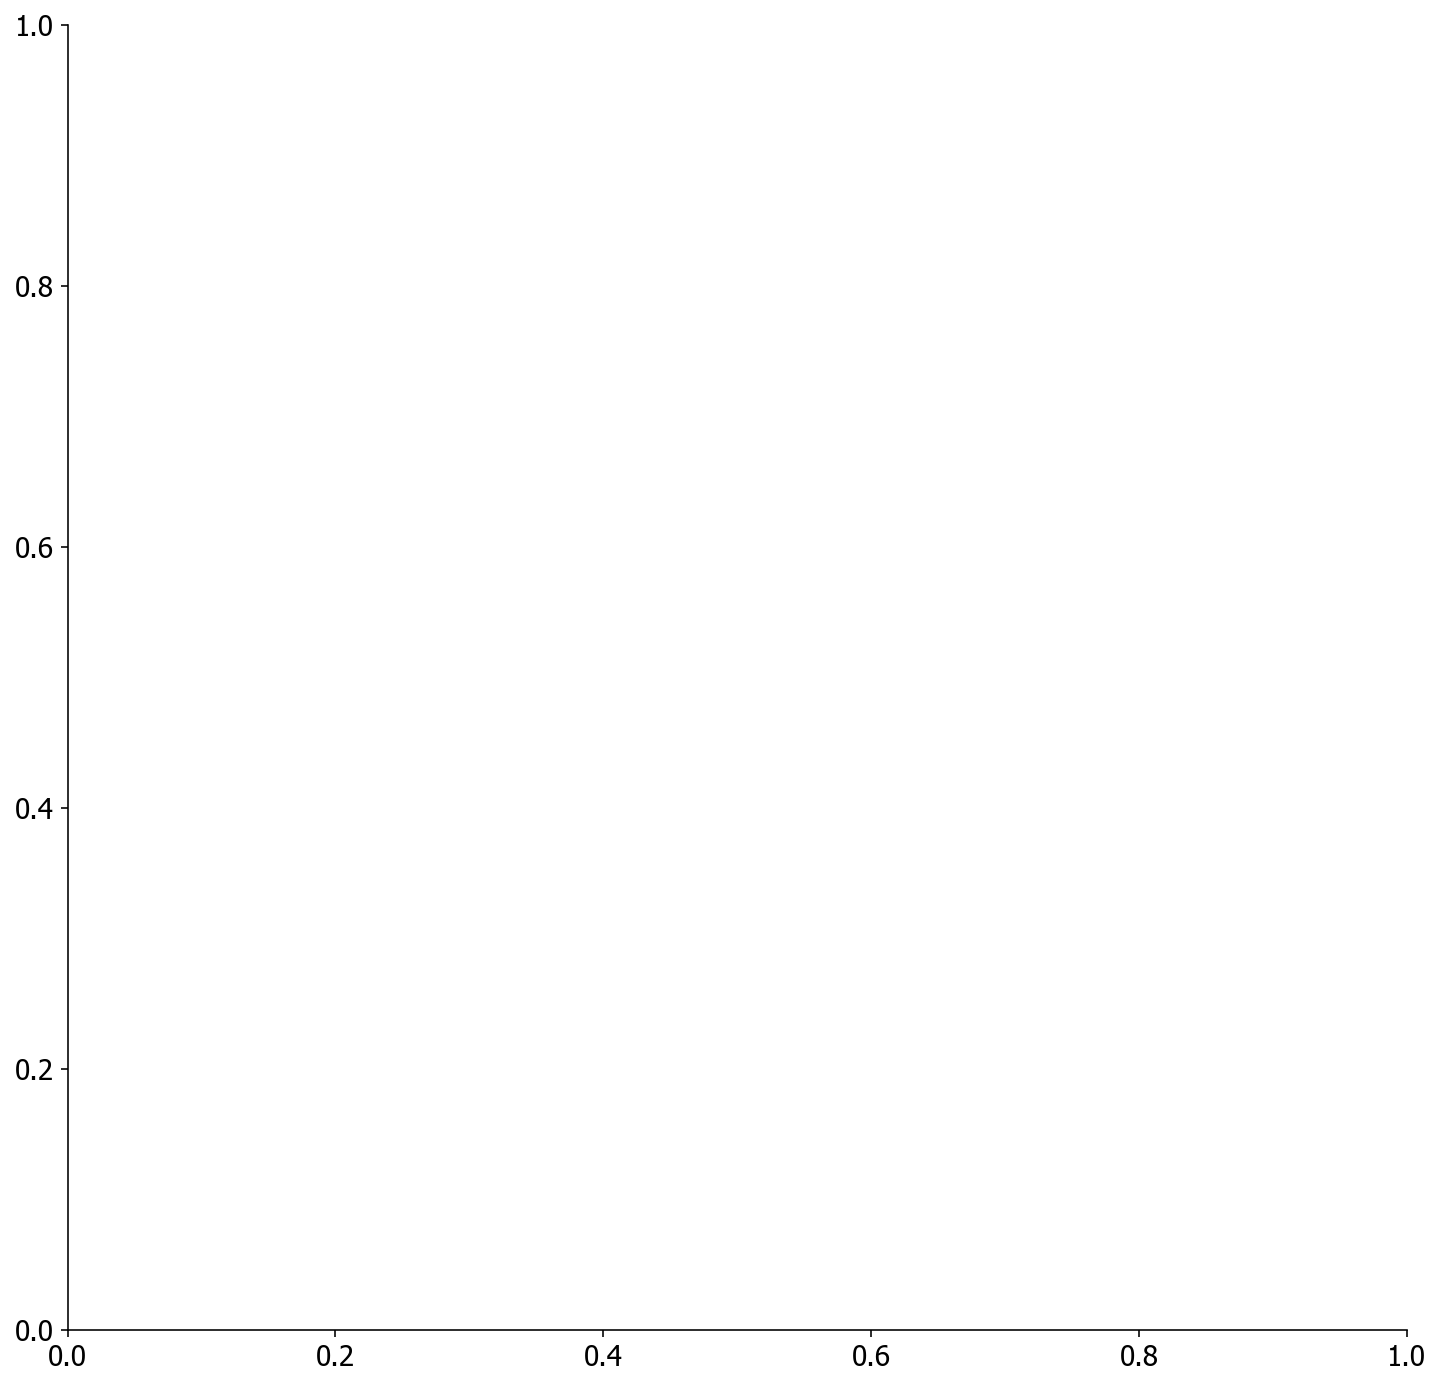

In [131]:
fig, ax = plt.subplots(figsize=(12,12))
zips.plot('medianErr', color='#D3D3D3', edgecolor='grey', alpha=0.4, ax=ax)
zips_more10.plot('medianErr', color='#778899', ax=ax)
zips_more20.plot('medianErr', color='#2F4F4F', ax=ax)
plt.axis('off')
plt.title('Zip code median prediction error', size=28)
plt.savefig(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project\notebooks\output\spatial_error_map.png', bbox_inches="tight")
plt.show()